## CALC log analysis

The following notebook assumes you have downloaded the CALC logs as CSV from [api.data.gov/admin](https://api.data.gov/admin/) and saved them as `logs.csv` in the same directory as this notebook.

In [2]:
import pandas

In [3]:
rows = pandas.read_csv('logs.csv', nrows=None, index_col=False, usecols=[
    'Time',
    'Method',
    'URL',
    'State',
    'Country',
    'City',
    'Status',
    'IP Address',
])

The following step is optional; we're removing identical requests coming from the same IP address. This might not actually be a great idea, especially if multiple actual users are behind the same IP address.

In [4]:
rows.drop_duplicates(subset=['Method', 'URL', 'IP Address'], inplace=True)

del rows['IP Address']

Now we'll filter only successful requests to the `/rates/` endpoint, which is the one used when users click the **Search** button (or initially load the page). We'll also parse the query string and add new columns that represent information about the search criteria.

In [206]:
from urllib.parse import urlparse, parse_qsl

RATES_URL = 'https://api.data.gov/gsa/calc/rates/'

rates = rows
rates = rates[rates['Method'] == 'GET']
rates = rates[rates['Status'] == 200]
rates = rates[rates['URL'].str.startswith(RATES_URL)]
rates['Time'] = rates['Time'].apply(pandas.to_datetime)
rates.index = rates['Time']

del rates['Method']
del rates['Status']
del rates['Time']

queries = rates['URL'].apply(
    lambda url: dict(parse_qsl(urlparse(url).query))
).apply(pandas.Series)

In [207]:
FIELD_DEFAULTS = {
    'Search terms': '',
    'Minimum experience': 0,
    'Maximum experience': 45,
    'Education level': '',
    'Worksite': '',
    'Business size': '',
    'Schedule': '',
    'Contract year': 'current',
    'Proposed price': '',
    'Query type': 'match_all',
    'Sort': 'current_price',
    'Rows excluded': 0,
}

rates['Search terms'] = queries['q'].str.lower().str.strip().str.replace(r',[ ]*$', '')
rates['Minimum experience'] = queries['min_experience'].apply(pandas.to_numeric)
rates['Maximum experience'] = queries['max_experience'].apply(pandas.to_numeric)
rates['Education level'] = queries['education']
rates['Worksite'] = queries['site']
rates['Business size'] = queries['business_size']
rates['Schedule'] = queries['schedule']
rates['Contract year'] = queries['contract-year']
rates['Proposed price'] = queries['proposed-price']
rates['Query type'] = queries['query_type']
rates['Sort'] = queries['sort']
rates['Rows excluded'] = queries['exclude'].str.split(',').str.len()

rates = rates.fillna(FIELD_DEFAULTS)

## Popular search terms

In [208]:
rates['Search terms'].value_counts().head(20).to_frame('Number of searches')

,Number of searches
,3629
subject matter expert,1444
project manager,1338
engineer,1125
program manager,1099
senior engineer,708
software engineer,593
consultant,447
systems engineer,435
training specialist,398


## Search customization

In [209]:
total_rates = rates.shape[0]
percentages = {}

for field, default in FIELD_DEFAULTS.items():
    non_default_rates = rates[rates[field] != default].shape[0]
    percentages[field] = int(non_default_rates / total_rates * 100)

pandas.Series(percentages).to_frame('%').sort_values(by='%', ascending=False)

,%
Search terms,92
Education level,44
Minimum experience,38
Maximum experience,37
Worksite,25
Business size,19
Rows excluded,15
Proposed price,14
Schedule,13
Sort,11


### How many searches had *no* customization, other than search term?

In [210]:
r = rates

for field, default in FIELD_DEFAULTS.items():
    if field == 'Search terms':
        continue
    r = r[r[field] == default]

r.shape[0] / total_rates

0.23256786715188021

## Distribution of minimum experience

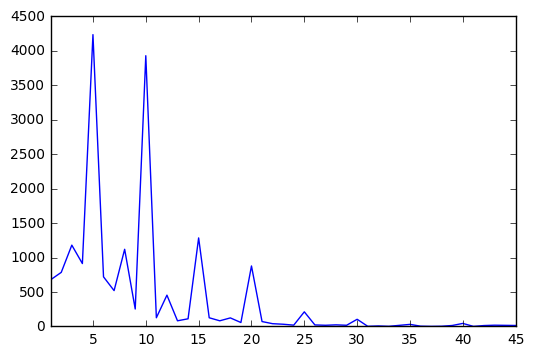

In [211]:
%matplotlib inline

rates[rates['Minimum experience'] > 0]['Minimum experience'].value_counts().sort_index().plot()

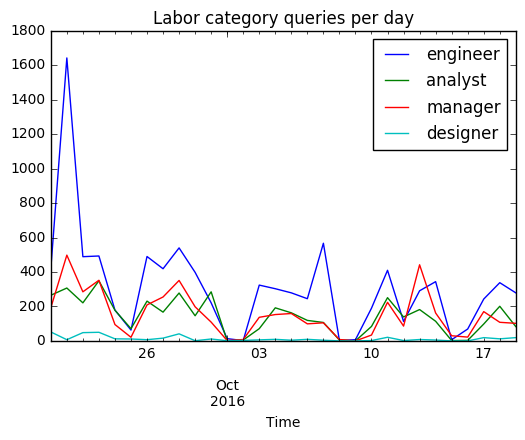

In [235]:
r = pandas.DataFrame()

for term in ['engineer', 'analyst', 'manager', 'designer']:
    r[term] = (rates['Search terms'].str.contains(term)).astype(int).resample('D').sum()

r.plot(title='Labor category queries per day')